In [52]:
# Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [54]:
# Read the Dataset
train = pd.read_csv(r"C:\Users\Zimm\Desktop\CodClause\train_data.csv")

In [56]:
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [60]:
train.describe()

,Emp_ID,Age,Salary,Joining Designation,Designation,Total Business Value,Quarterly Rating
count,19104.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.650283,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.264471,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [62]:
train['MMM-YY'].describe()

count          19104
unique            24
top       2016-01-01
freq            1022
Name: MMM-YY, dtype: object

In [64]:
train['MMM-YY'] = pd.to_datetime(train['MMM-YY'])
train['Dateofjoining'] = pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])

# Feature Engineering

In [67]:
uniqueemployeesdata= train[['Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'Joining Designation','Designation']].drop_duplicates()

In [69]:
# Get the target column set
employeeswholeft = train[~train['LastWorkingDate'].isna()]
employeeswholeft['Y']=0
uniqueemployeesdata = uniqueemployeesdata.merge(employeeswholeft[['Emp_ID','Y']],on='Emp_ID',how='left')
uniqueemployeesdata['Y']=uniqueemployeesdata['Y'].fillna(1)

In [71]:
employeeage = train.groupby('Emp_ID').count()['City']
employeeage = employeeage.reset_index()
employeeage.columns = ['Emp_ID','Periodwithus']
uniqueemployeesdata=  uniqueemployeesdata.merge(employeeage,on='Emp_ID',how='left')

In [73]:
uniqueemployeesdata = uniqueemployeesdata.merge(pd.pivot_table(train,index='Emp_ID',values=['Total Business Value','Quarterly Rating'],aggfunc='mean').reset_index(),on='Emp_ID',how='left')

In [75]:
# Time business done
uniqueemployeesdata['timesbusinessdone'] = uniqueemployeesdata['Total Business Value']/uniqueemployeesdata['Salary']

In [77]:
# Reversal happend for employees
reversals = train[train['Total Business Value']<0]
reversals['reversal']=1
uniqueemployeesdata=uniqueemployeesdata.merge(reversals[['Emp_ID','reversal']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['reversal']=uniqueemployeesdata['reversal'].fillna(0)

In [79]:
# Zero business count
zeroperformance = train[train['Total Business Value']==0]
zeroperformance = zeroperformance.groupby('Emp_ID').count()['Age'].reset_index()
zeroperformance.columns = ['Emp_ID','zeroperformance']
uniqueemployeesdata = uniqueemployeesdata.merge(zeroperformance.drop_duplicates(),on='Emp_ID',how='left')

In [81]:
# Months where coverage less than salary
train['timesbusiness'] = train['Total Business Value']/train['Salary']
businesslesscoverage = train[train['timesbusiness']<1]
businesslesscoverage=businesslesscoverage.groupby('Emp_ID').count()['Age'].reset_index()
businesslesscoverage.columns=['Emp_ID','Businesslessthansalary']
uniqueemployeesdata=uniqueemployeesdata.merge(businesslesscoverage[['Emp_ID','Businesslessthansalary']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['Businesslessthansalary']=uniqueemployeesdata['Businesslessthansalary'].fillna(0)

In [83]:
# Change in designation
changedesignation = train[train['Joining Designation'] != train['Designation']]
changedesignation['changedesignation']=1
changedesignation = changedesignation[['Emp_ID','changedesignation']].drop_duplicates()
uniqueemployeesdata = uniqueemployeesdata.merge(changedesignation[['Emp_ID','changedesignation']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['changedesignation'] = uniqueemployeesdata['changedesignation'].fillna(0)

In [85]:
# Last rating before leaving
lastrating = train[['Emp_ID','Quarterly Rating']].drop_duplicates( subset='Emp_ID',keep='last')
lastrating.columns = ['Emp_ID','Last Rating']
uniqueemployeesdata = uniqueemployeesdata.merge(lastrating,on='Emp_ID',how='left')

In [87]:
uniqueemployeesdata.head()

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,Joining Designation,Designation,Y,Periodwithus,Quarterly Rating,Total Business Value,timesbusinessdone,reversal,zeroperformance,Businesslessthansalary,changedesignation,Last Rating
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,0.0,3,2.0,571860.0,9.964975,1.0,1.0,2.0,0.0,2
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,1.0,2,1.0,0.0,0.000000,0.0,2.0,2.0,0.0,1
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,0.0,5,1.0,70000.0,1.067024,0.0,4.0,4.0,0.0,1
3,5,29,Male,C9,College,46368,2016-01-09,1,1,0.0,3,1.0,40120.0,0.865252,0.0,2.0,2.0,0.0,1
4,6,31,Female,C11,Bachelor,78728,2017-07-31,3,3,1.0,5,1.6,253000.0,3.213596,0.0,4.0,4.0,0.0,2


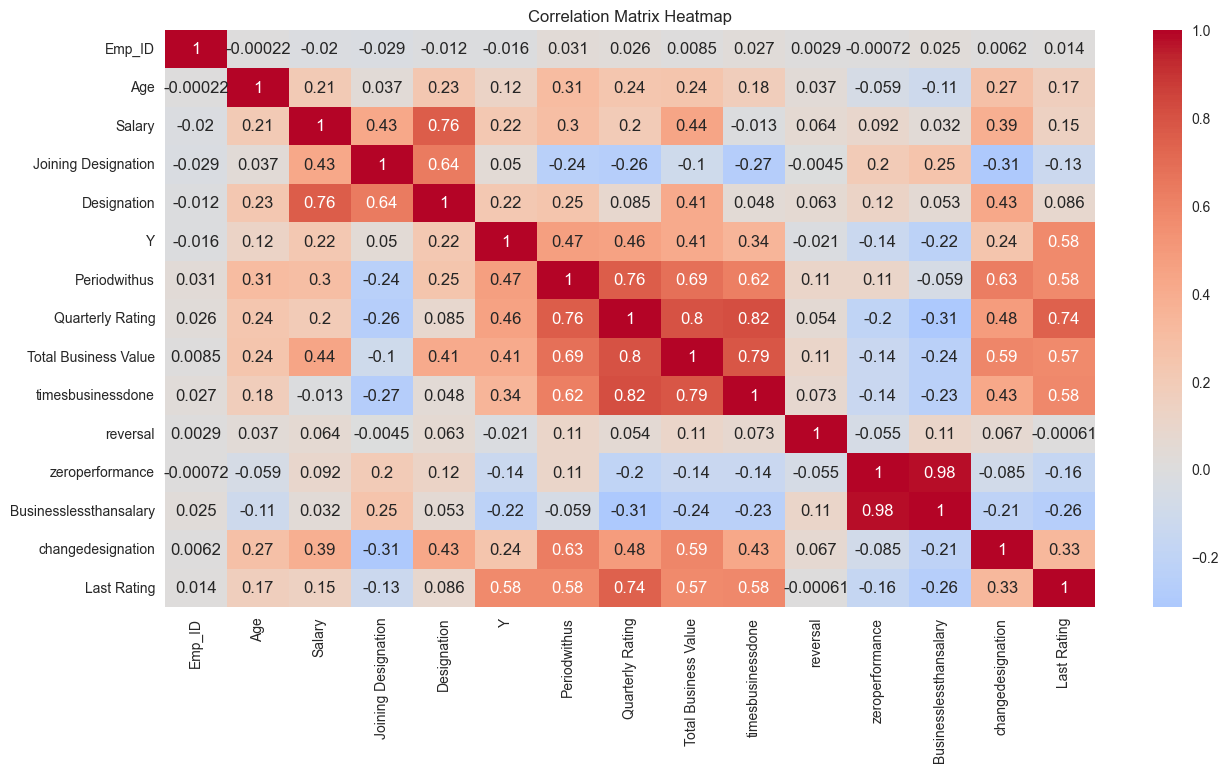

In [89]:
# Select only numeric columns for correlation calculation
numeric_cols = uniqueemployeesdata.select_dtypes(include=[np.number]).columns
df4_corr = uniqueemployeesdata[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(15, 7.5))
sns.heatmap(df4_corr, annot=True, cmap='coolwarm', center=0)

# Add a title
plt.title('Correlation Matrix Heatmap')

# Show plot
plt.show()

# Model Evaluation

In [94]:
from pycaret.classification import *
s = setup(uniqueemployeesdata, target = 'Y', ignore_features = ['Emp_ID','Dateofjoining'])

,Description,Value
0,Session id,2461
1,Target,Y
2,Target type,Binary
3,Original data shape,"(3786, 19)"
4,Transformed data shape,"(3786, 19)"
5,Transformed train set shape,"(2650, 19)"
6,Transformed test set shape,"(1136, 19)"
7,Ignore features,2
8,Numeric features,13
9,Categorical features,3


In [96]:
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8864,0.9474,0.8118,0.8847,0.8462,0.7565,0.7587,0.1360
rf,Random Forest Classifier,0.8921,0.9439,0.8157,0.8962,0.8535,0.7685,0.7711,0.1720
lightgbm,Light Gradient Boosting Machine,0.8830,0.9437,0.8050,0.8825,0.8417,0.7493,0.7516,0.5790
xgboost,Extreme Gradient Boosting,0.8864,0.9398,0.8255,0.8738,0.8486,0.7579,0.7590,0.0720
gbc,Gradient Boosting Classifier,0.8566,0.9209,0.7396,0.8714,0.7994,0.6891,0.6953,0.1420
ada,Ada Boost Classifier,0.8325,0.9062,0.7230,0.8235,0.7692,0.6387,0.6426,0.0860
ridge,Ridge Classifier,0.8155,0.8643,0.6508,0.8369,0.7308,0.5941,0.6059,0.0390
lda,Linear Discriminant Analysis,0.8151,0.8641,0.6518,0.8350,0.7307,0.5935,0.6050,0.0370
lr,Logistic Regression,0.8185,0.8605,0.6820,0.8194,0.7434,0.6050,0.6119,0.1140
dt,Decision Tree Classifier,0.8506,0.8452,0.8215,0.7981,0.8094,0.6866,0.6870,0.0350


In [98]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2461, verbose=0,
                     warm_start=False)

In [100]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8642,0.8967,0.7941,0.8438,0.8182,0.7099,0.7107
1,0.8226,0.8725,0.7451,0.7835,0.7638,0.6220,0.6225
2,0.8566,0.9160,0.7647,0.8478,0.8041,0.6915,0.6938
3,0.8264,0.8928,0.7549,0.7857,0.7700,0.6307,0.6310
4,0.8151,0.8536,0.6961,0.7978,0.7435,0.6000,0.6034
5,0.8189,0.8744,0.7184,0.7957,0.7551,0.6120,0.6140
6,0.8113,0.8926,0.7573,0.7573,0.7573,0.6030,0.6030
7,0.8113,0.8576,0.7670,0.7524,0.7596,0.6044,0.6044
8,0.8340,0.8937,0.6893,0.8554,0.7634,0.6378,0.6466


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


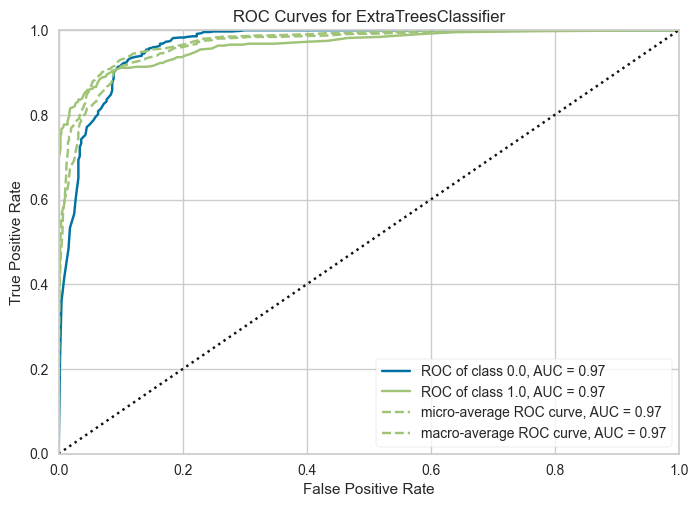

In [102]:
# Performance of coverage
plot_model(tuned_best_model, plot = 'auc')

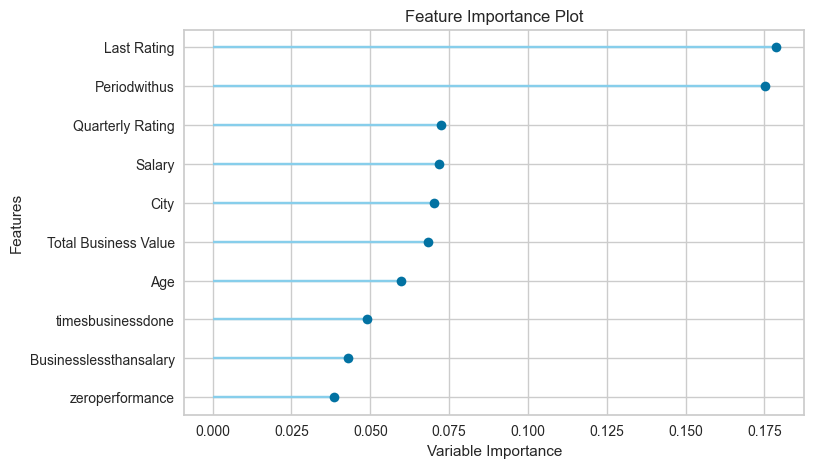

In [103]:
# Feature importance
plot_model(tuned_best_model, plot = 'feature')

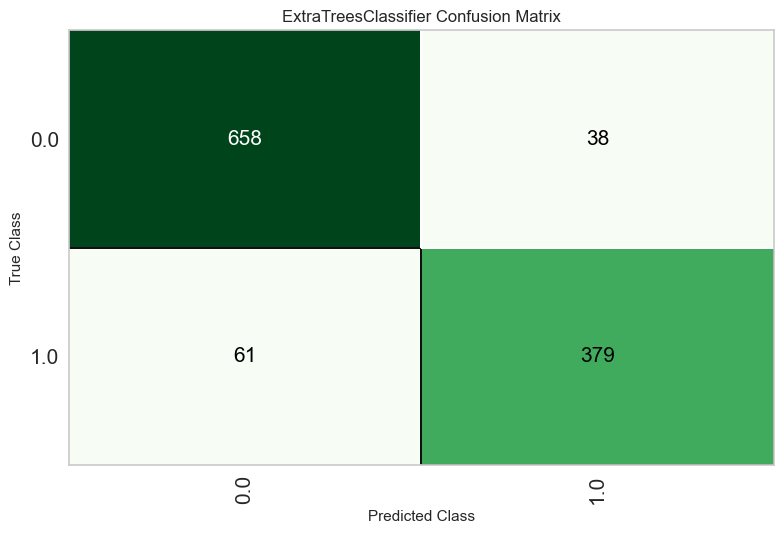

In [106]:
# Confusion matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

# Prediction On Test Data

In [110]:
# Read the Test Data
test = pd.read_csv(r"C:\Users\Zimm\Desktop\CodClause\test_data.csv")

In [112]:
testset = uniqueemployeesdata[uniqueemployeesdata['Emp_ID'].isin(test['Emp_ID'])]
testset= testset.drop_duplicates()

In [114]:
et = create_model('et')
tuned_et = tune_model(et)
predict_model(tuned_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9094,0.9648,0.8627,0.8980,0.8800,0.8073,0.8077
1,0.8981,0.9556,0.8627,0.8713,0.8670,0.7844,0.7845
2,0.9094,0.9725,0.8529,0.9062,0.8788,0.8066,0.8075
3,0.9057,0.9712,0.8333,0.9140,0.8718,0.7974,0.7995
4,0.8491,0.9149,0.7353,0.8523,0.7895,0.6728,0.6773
5,0.8906,0.9420,0.8252,0.8854,0.8543,0.7668,0.7680
6,0.8943,0.9585,0.8155,0.9032,0.8571,0.7737,0.7762
7,0.8792,0.9314,0.8058,0.8737,0.8384,0.7422,0.7438
8,0.8906,0.9417,0.8155,0.8936,0.8528,0.7660,0.7680


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8642,0.8967,0.7941,0.8438,0.8182,0.7099,0.7107
1,0.8226,0.8725,0.7451,0.7835,0.7638,0.6220,0.6225
2,0.8566,0.9160,0.7647,0.8478,0.8041,0.6915,0.6938
3,0.8264,0.8928,0.7549,0.7857,0.7700,0.6307,0.6310
4,0.8151,0.8536,0.6961,0.7978,0.7435,0.6000,0.6034
5,0.8189,0.8744,0.7184,0.7957,0.7551,0.6120,0.6140
6,0.8113,0.8926,0.7573,0.7573,0.7573,0.6030,0.6030
7,0.8113,0.8576,0.7670,0.7524,0.7596,0.6044,0.6044
8,0.8340,0.8937,0.6893,0.8554,0.7634,0.6378,0.6466


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9129,0.9653,0.8614,0.9089,0.8845,0.8146,0.8154


,Age,Gender,City,Education_Level,Salary,Joining Designation,Designation,Periodwithus,Quarterly Rating,Total Business Value,timesbusinessdone,reversal,zeroperformance,Businesslessthansalary,changedesignation,Last Rating,Y,prediction_label,prediction_score
3729,29,Male,C1,Bachelor,22217,1,1,9,2.000000,2.038267e+05,9.174356,0.0,4.0,4.0,0.0,1,0.0,0,1.00
3361,25,Female,C25,Bachelor,29052,1,1,6,2.000000,3.620433e+05,12.461907,0.0,3.0,3.0,0.0,1,0.0,0,0.97
2465,30,Male,C15,College,80368,2,2,7,2.285714,5.955800e+05,7.410661,0.0,3.0,3.0,0.0,4,1.0,1,0.87
2298,33,Male,C17,College,35823,1,1,4,1.000000,0.000000e+00,0.000000,0.0,4.0,4.0,0.0,1,0.0,0,0.99
2538,45,Male,C21,Bachelor,77647,3,3,11,1.272727,3.891345e+05,5.011585,0.0,3.0,3.0,0.0,1,0.0,0,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,39,Male,C14,Master,59166,1,1,17,2.764706,5.294424e+05,8.948422,0.0,2.0,2.0,0.0,1,0.0,0,1.00
2836,38,Male,C19,College,131847,5,5,24,1.375000,8.411312e+05,6.379601,0.0,10.0,10.0,0.0,1,1.0,1,1.00
3111,25,Female,C29,College,76455,1,1,2,1.000000,0.000000e+00,0.000000,0.0,2.0,2.0,0.0,1,1.0,0,0.60
380,32,Female,C20,Bachelor,65094,1,2,24,3.000000,1.245894e+06,19.139917,0.0,5.0,5.0,1.0,4,1.0,1,1.00


In [115]:
final_et = finalize_model(tuned_et)
unseen_predictions = predict_model(final_et, data=testset)
predictionsfinal= unseen_predictions[['Emp_ID','prediction_label']].drop_duplicates()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,1.0000,0,1.0000,1.0000,1.0000,nan,0.0000


In [117]:
predictionsfinal.head()

,Emp_ID,prediction_label
1,2,1
4,6,1
6,11,1
11,14,1
23,25,1


In [118]:
predictionsfinal = predictionsfinal.drop_duplicates( subset='Emp_ID',keep='last')
predictionsfinal.to_csv('predictions.csv')